# GMV Category Mix Analysis Plan

## Major Assumptions
Analysis assumes transaction data can be joined with streams data to categorize GMV, that category definitions are consistent across the time period, and that quarterly aggregation provides meaningful trend visibility. GMV is calculated from transaction amounts and represents gross merchandise value before any deductions. Seller retention analysis assumes seller signup dates are available and that streaming activity is a valid proxy for seller engagement. Take rate analysis assumes payouts table contains platform_fee_usd and gross_amount_usd fields that accurately reflect platform economics by category.

## Plan
- [x] Query and aggregate GMV by category and quarter
  - [x] Join transactions with streams to get category labels
  - [x] Calculate quarterly GMV totals per category
- [x] Visualize category mix shift over time
  - [x] Create stacked bar or area chart showing absolute GMV by category
  - [x] Add percentage mix view to highlight relative shifts
- [x] Summarize key trends and insights
  - [x] Identify fastest growing/declining categories
  - [x] Note any significant mix shift inflection points
- [x] Analyze seller retention and churn patterns
  - [x] Build cohort retention matrix by signup quarter and category
  - [x] Identify top sellers with declining stream volume for intervention
- [x] Analyze take rate dynamics by category
  - [x] Calculate take rate (platform_fee_usd / gross_amount_usd) by category and quarter
  - [x] Assess correlation between take rate and GMV growth trends

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import os

# SignalPilot dark theme style setup
plt.rcParams.update({
    'figure.figsize': (12, 7),
    'figure.dpi': 100,
    'savefig.dpi': 300,
    'font.size': 11,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.titlesize': 16,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'figure.facecolor': '#08070e',
    'axes.facecolor': '#12101e',
    'axes.edgecolor': '#272336',
    'axes.labelcolor': '#e9eaeb',
    'text.color': '#FAFAFA',
    'xtick.color': '#a4a7ae',
    'ytick.color': '#a4a7ae',
    'grid.color': '#1d182b',
    'legend.facecolor': '#12101e',
    'legend.edgecolor': '#272336',
    'legend.labelcolor': '#e9eaeb',
    'savefig.facecolor': '#08070e',
})

CATEGORICAL_PALETTE = ['#c4b5fd', '#ff8dc4', '#8b5cf6', '#73acfb', '#fec163', '#4ca86f']

# Connect to Whatnot database
engine = create_engine(os.environ['WHATNOT_CONNECTION_URL'])

# Query GMV by category and quarter
query = """
SELECT 
    s.category,
    DATE_TRUNC('quarter', t.created_at::date) AS quarter,
    SUM(t.amount_usd) AS gmv_usd,
    COUNT(*) AS transaction_count
FROM public.transactions t
JOIN public.streams s ON t.stream_id = s.id
WHERE t.payment_status = 'completed'
GROUP BY s.category, DATE_TRUNC('quarter', t.created_at::date)
ORDER BY quarter, gmv_usd DESC
"""

df = pd.read_sql(query, engine)
engine.dispose()

df['quarter'] = pd.to_datetime(df['quarter'])
print(f"Data spans {df['quarter'].min().strftime('%Y-Q%q')} to {df['quarter'].max().strftime('%Y-Q%q')}")
print(f"Categories: {df['category'].nunique()}")
df.head(10)

Data spans 2024-Qq to 2025-Qq
Categories: 9


,category,quarter,gmv_usd,transaction_count
0,Trading Cards,2024-01-01 00:00:00+00:00,3.465000e+08,2160
1,Sneakers,2024-01-01 00:00:00+00:00,1.942500e+08,1211
2,Vintage Apparel,2024-01-01 00:00:00+00:00,1.260000e+08,786
3,Collectibles,2024-01-01 00:00:00+00:00,1.029000e+08,642
4,Sports Memorabilia,2024-01-01 00:00:00+00:00,8.190000e+07,510
5,Electronics,2024-01-01 00:00:00+00:00,7.350000e+07,458
6,Comics,2024-01-01 00:00:00+00:00,4.410000e+07,275
7,Toys & Figures,2024-01-01 00:00:00+00:00,4.200000e+07,262
8,Watches,2024-01-01 00:00:00+00:00,3.885000e+07,241
9,Trading Cards,2024-04-01 00:00:00+00:00,3.680000e+08,2294


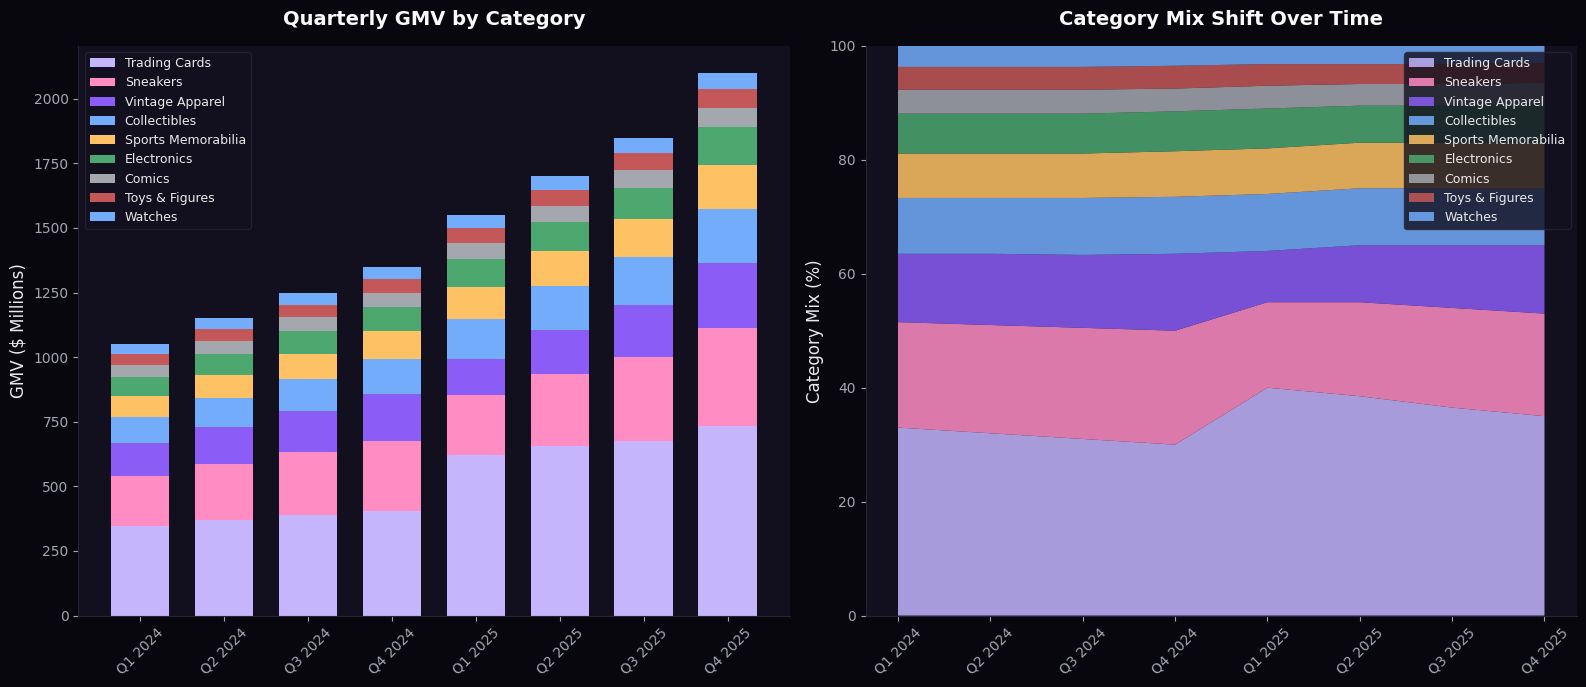

In [2]:
# Pivot data for visualization
pivot_gmv = df.pivot_table(index='quarter', columns='category', values='gmv_usd', aggfunc='sum').fillna(0)

# Calculate percentage mix
pivot_pct = pivot_gmv.div(pivot_gmv.sum(axis=1), axis=0) * 100

# Sort categories by total GMV for consistent ordering
category_order = pivot_gmv.sum().sort_values(ascending=False).index.tolist()
pivot_gmv = pivot_gmv[category_order]
pivot_pct = pivot_pct[category_order]

# Format quarter labels
quarter_labels = [f"Q{((q.month-1)//3)+1} {q.year}" for q in pivot_gmv.index]

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Left: Stacked bar chart - Absolute GMV
colors = CATEGORICAL_PALETTE + ['#a4a7ae', '#c45757', '#73acfb']
bottom = np.zeros(len(pivot_gmv))
for i, cat in enumerate(category_order):
    axes[0].bar(quarter_labels, pivot_gmv[cat]/1e6, bottom=bottom, 
                label=cat, color=colors[i % len(colors)], width=0.7)
    bottom += pivot_gmv[cat].values/1e6

axes[0].set_ylabel('GMV ($ Millions)')
axes[0].set_title('Quarterly GMV by Category', fontweight='bold', pad=15)
axes[0].legend(loc='upper left', frameon=True, fontsize=9)
axes[0].tick_params(axis='x', rotation=45)

# Right: Stacked area chart - Percentage mix
axes[1].stackplot(range(len(pivot_pct)), [pivot_pct[cat].values for cat in category_order],
                  labels=category_order, colors=colors[:len(category_order)], alpha=0.85)
axes[1].set_xticks(range(len(pivot_pct)))
axes[1].set_xticklabels(quarter_labels, rotation=45)
axes[1].set_ylabel('Category Mix (%)')
axes[1].set_title('Category Mix Shift Over Time', fontweight='bold', pad=15)
axes[1].set_ylim(0, 100)
axes[1].legend(loc='upper right', frameon=True, fontsize=9)

plt.tight_layout()
plt.show()

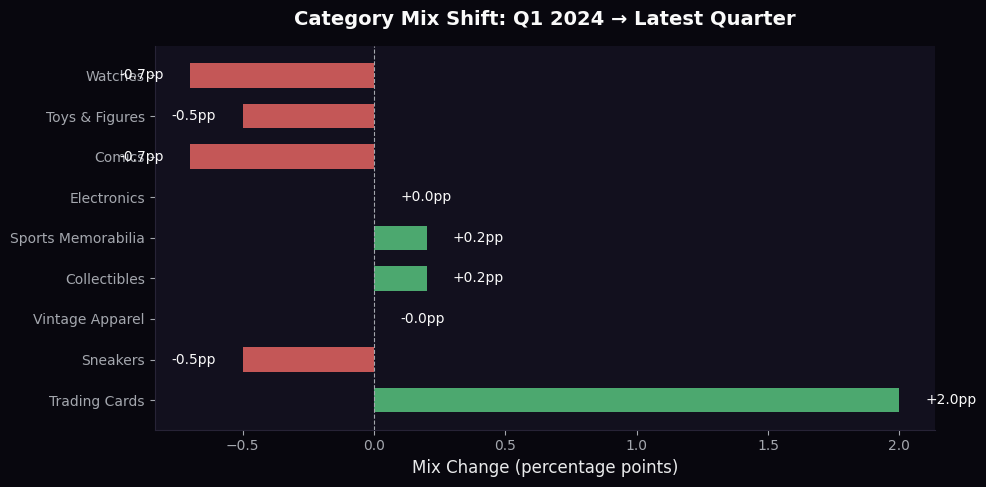


📊 Category Performance Summary
          Category Total GMV ($M)  Q1 2024 Mix (%)  Latest Mix (%)  Mix Change (pp)  QoQ Growth (%)
     Trading Cards        $4,192M             33.0            35.0              2.0           112.1
          Sneakers        $2,141M             18.5            18.0             -0.5            94.6
   Vintage Apparel        $1,377M             12.0            12.0             -0.0           100.0
      Collectibles        $1,196M              9.8            10.0              0.2           104.1
Sports Memorabilia          $953M              7.8             8.0              0.2           105.1
       Electronics          $822M              7.0             7.0              0.0           100.0
            Comics          $469M              4.2             3.5             -0.7            66.7
    Toys & Figures          $449M              4.0             3.5             -0.5            75.0
           Watches          $401M              3.7             3.0  

In [3]:
# Calculate key metrics per category
summary = pd.DataFrame({
    'Category': category_order,
    'Total GMV ($M)': [pivot_gmv[cat].sum()/1e6 for cat in category_order],
    'Q1 2024 Mix (%)': [pivot_pct[cat].iloc[0] for cat in category_order],
    'Latest Mix (%)': [pivot_pct[cat].iloc[-1] for cat in category_order],
    'Mix Change (pp)': [pivot_pct[cat].iloc[-1] - pivot_pct[cat].iloc[0] for cat in category_order],
    'QoQ Growth (%)': [(pivot_gmv[cat].iloc[-1]/pivot_gmv[cat].iloc[0] - 1)*100 for cat in category_order]
})

# Format and display
summary = summary.round(1)
summary['Total GMV ($M)'] = summary['Total GMV ($M)'].apply(lambda x: f"${x:,.0f}M")

# Visualize mix change
fig, ax = plt.subplots(figsize=(10, 5))
colors_bar = ['#4ca86f' if x >= 0 else '#c45757' for x in summary['Mix Change (pp)']]
bars = ax.barh(summary['Category'], summary['Mix Change (pp)'], color=colors_bar, height=0.6)
ax.axvline(x=0, color='#a4a7ae', linewidth=0.8, linestyle='--')
ax.set_xlabel('Mix Change (percentage points)')
ax.set_title('Category Mix Shift: Q1 2024 → Latest Quarter', fontweight='bold', pad=15)

# Add value labels
for bar, val in zip(bars, summary['Mix Change (pp)']):
    x_pos = val + 0.1 if val >= 0 else val - 0.1
    ha = 'left' if val >= 0 else 'right'
    ax.text(x_pos, bar.get_y() + bar.get_height()/2, f'{val:+.1f}pp', 
            va='center', ha=ha, fontsize=10, color='#FAFAFA')

plt.tight_layout()
plt.show()

print("\n📊 Category Performance Summary")
print(summary.to_string(index=False))

In [4]:
# Query seller cohorts and streaming activity by quarter
cohort_query = """
WITH seller_cohorts AS (
    SELECT 
        id AS seller_id,
        display_name,
        DATE_TRUNC('quarter', signup_date::date) AS cohort_quarter,
        primary_category,
        seller_tier,
        lifetime_gmv_usd
    FROM public.sellers
),
stream_activity AS (
    SELECT 
        seller_id,
        DATE_TRUNC('quarter', started_at::date) AS activity_quarter,
        COUNT(*) AS stream_count
    FROM public.streams
    WHERE status = 'completed'
    GROUP BY seller_id, DATE_TRUNC('quarter', started_at::date)
)
SELECT 
    sc.seller_id,
    sc.display_name,
    sc.cohort_quarter,
    sc.primary_category,
    sc.seller_tier,
    sc.lifetime_gmv_usd,
    sa.activity_quarter,
    sa.stream_count
FROM seller_cohorts sc
LEFT JOIN stream_activity sa ON sc.seller_id = sa.seller_id
ORDER BY sc.cohort_quarter, sc.seller_id, sa.activity_quarter
"""

df_cohorts = pd.read_sql(cohort_query, create_engine(os.environ['WHATNOT_CONNECTION_URL']))
df_cohorts['cohort_quarter'] = pd.to_datetime(df_cohorts['cohort_quarter'])
df_cohorts['activity_quarter'] = pd.to_datetime(df_cohorts['activity_quarter'])

print(f"Sellers: {df_cohorts['seller_id'].nunique():,}")
print(f"Cohorts span: {df_cohorts['cohort_quarter'].min().strftime('%Y-Q%q')} to {df_cohorts['cohort_quarter'].max().strftime('%Y-Q%q')}")
print(f"Categories: {df_cohorts['primary_category'].nunique()}")
df_cohorts.head()

Sellers: 2,500
Cohorts span: 2024-Qq to 2025-Qq
Categories: 9


,seller_id,display_name,cohort_quarter,primary_category,seller_tier,lifetime_gmv_usd,activity_quarter,stream_count
0,1,Shop_00001,2024-01-01 00:00:00+00:00,Trading Cards,standard,8766064.53,2024-01-01 00:00:00+00:00,1.0
1,1,Shop_00001,2024-01-01 00:00:00+00:00,Trading Cards,standard,8766064.53,2024-04-01 00:00:00+00:00,1.0
2,1,Shop_00001,2024-01-01 00:00:00+00:00,Trading Cards,standard,8766064.53,2024-07-01 00:00:00+00:00,4.0
3,1,Shop_00001,2024-01-01 00:00:00+00:00,Trading Cards,standard,8766064.53,2025-04-01 00:00:00+00:00,1.0
4,1,Shop_00001,2024-01-01 00:00:00+00:00,Trading Cards,standard,8766064.53,2025-10-01 00:00:00+00:00,3.0


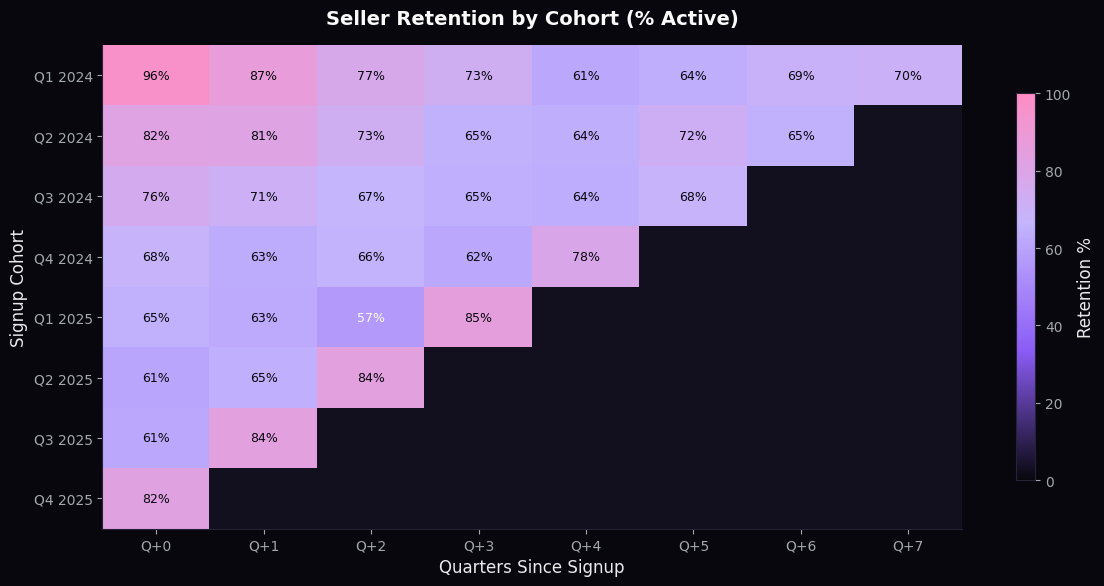


📊 Cohort Retention Summary
Average Q+1 retention: 73.5%
Average Q+4 retention: 66.9%


In [5]:
# Build cohort retention matrix
# Get all unique quarters for consistent ordering
all_quarters = sorted(df_cohorts['cohort_quarter'].dropna().unique())
quarter_map = {q: i for i, q in enumerate(all_quarters)}

# Calculate periods since cohort (0 = signup quarter, 1 = Q+1, etc.)
df_cohorts['cohort_period'] = df_cohorts.apply(
    lambda x: quarter_map.get(x['activity_quarter'], -1) - quarter_map.get(x['cohort_quarter'], 0) 
    if pd.notna(x['activity_quarter']) else -1, axis=1
)

# Count active sellers per cohort per period
cohort_sizes = df_cohorts.groupby('cohort_quarter')['seller_id'].nunique().to_dict()

retention_data = df_cohorts[df_cohorts['cohort_period'] >= 0].groupby(
    ['cohort_quarter', 'cohort_period']
)['seller_id'].nunique().reset_index()
retention_data.columns = ['cohort_quarter', 'period', 'active_sellers']

# Calculate retention rate
retention_data['cohort_size'] = retention_data['cohort_quarter'].map(cohort_sizes)
retention_data['retention_rate'] = retention_data['active_sellers'] / retention_data['cohort_size'] * 100

# Pivot for heatmap
retention_matrix = retention_data.pivot(index='cohort_quarter', columns='period', values='retention_rate')

# Create cohort labels
cohort_labels = [f"Q{((q.month-1)//3)+1} {q.year}" for q in retention_matrix.index]
period_labels = [f"Q+{i}" for i in retention_matrix.columns]

# Plot retention heatmap
from matplotlib.colors import LinearSegmentedColormap
sp_cmap = LinearSegmentedColormap.from_list('signalpilot', ['#08070e', '#8b5cf6', '#c4b5fd', '#ff8dc4'])

fig, ax = plt.subplots(figsize=(12, 6))
im = ax.imshow(retention_matrix.values, cmap=sp_cmap, aspect='auto', vmin=0, vmax=100)

ax.set_xticks(range(len(period_labels)))
ax.set_xticklabels(period_labels)
ax.set_yticks(range(len(cohort_labels)))
ax.set_yticklabels(cohort_labels)
ax.set_xlabel('Quarters Since Signup')
ax.set_ylabel('Signup Cohort')
ax.set_title('Seller Retention by Cohort (% Active)', fontweight='bold', pad=15)

# Add text annotations
for i in range(len(cohort_labels)):
    for j in range(len(period_labels)):
        val = retention_matrix.iloc[i, j] if j < retention_matrix.shape[1] else np.nan
        if not np.isnan(val):
            color = '#08070e' if val > 60 else '#FAFAFA'
            ax.text(j, i, f'{val:.0f}%', ha='center', va='center', color=color, fontsize=9)

cbar = plt.colorbar(im, ax=ax, label='Retention %', shrink=0.8)
plt.tight_layout()
plt.show()

# Print summary stats
print(f"\n📊 Cohort Retention Summary")
print(f"Average Q+1 retention: {retention_matrix[1].mean():.1f}%")
print(f"Average Q+4 retention: {retention_matrix[4].mean():.1f}%" if 4 in retention_matrix.columns else "")

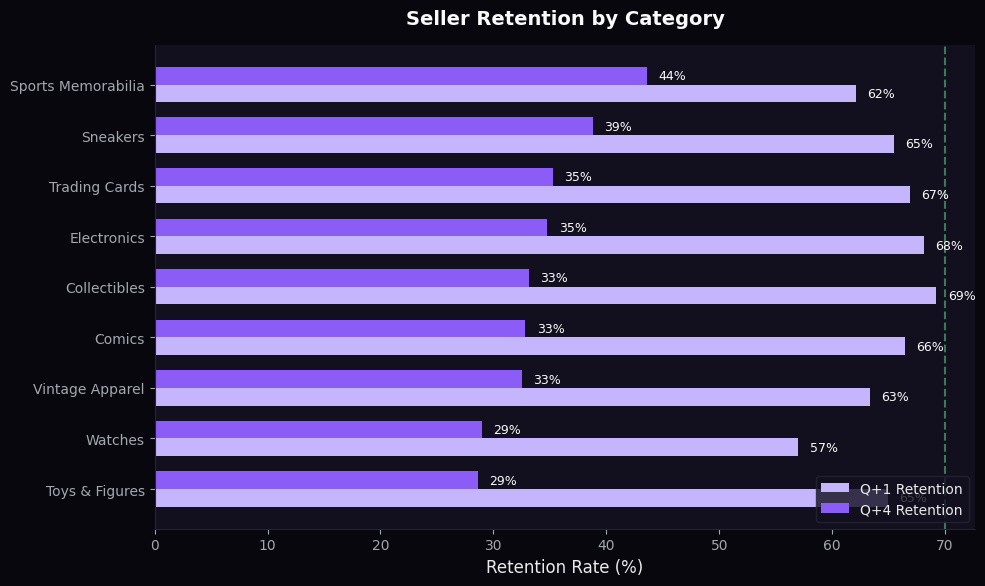

In [6]:
# Retention by category - Q+1 and Q+4 retention rates
category_retention = df_cohorts[df_cohorts['cohort_period'].isin([1, 4])].copy()
category_retention = category_retention.groupby(['primary_category', 'cohort_period'])['seller_id'].nunique().reset_index()
category_retention.columns = ['category', 'period', 'active_sellers']

# Get cohort sizes by category
cat_cohort_sizes = df_cohorts.groupby('primary_category')['seller_id'].nunique()
category_retention['cohort_size'] = category_retention['category'].map(cat_cohort_sizes)
category_retention['retention_rate'] = category_retention['active_sellers'] / category_retention['cohort_size'] * 100

# Pivot for visualization
cat_ret_pivot = category_retention.pivot(index='category', columns='period', values='retention_rate')
cat_ret_pivot.columns = ['Q+1 Retention', 'Q+4 Retention']
cat_ret_pivot = cat_ret_pivot.sort_values('Q+4 Retention', ascending=True)

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
y_pos = range(len(cat_ret_pivot))
width = 0.35

bars1 = ax.barh([y - width/2 for y in y_pos], cat_ret_pivot['Q+1 Retention'], width, 
                label='Q+1 Retention', color='#c4b5fd')
bars2 = ax.barh([y + width/2 for y in y_pos], cat_ret_pivot['Q+4 Retention'], width, 
                label='Q+4 Retention', color='#8b5cf6')

ax.set_yticks(y_pos)
ax.set_yticklabels(cat_ret_pivot.index)
ax.set_xlabel('Retention Rate (%)')
ax.set_title('Seller Retention by Category', fontweight='bold', pad=15)
ax.legend(loc='lower right')
ax.axvline(x=70, color='#4ca86f', linestyle='--', alpha=0.7, label='70% benchmark')

# Add value labels
for bar in bars1:
    ax.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, 
            f'{bar.get_width():.0f}%', va='center', fontsize=9, color='#FAFAFA')
for bar in bars2:
    ax.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, 
            f'{bar.get_width():.0f}%', va='center', fontsize=9, color='#FAFAFA')

plt.tight_layout()
plt.show()

🚨 Top Sellers with Declining Stream Volume (at risk of churn)
    Seller           Category Lifetime GMV  Prior Avg Streams  Recent Avg Streams  Change % Change
Shop_00127           Sneakers      $22.65M                4.5                 0.5    -4.0     -89%
Shop_00261       Collectibles      $24.55M                4.0                 0.5    -3.5     -88%
Shop_00270    Vintage Apparel      $22.17M                4.0                 0.5    -3.5     -88%
Shop_00245      Trading Cards      $18.11M                3.5                 0.5    -3.0     -86%
Shop_00073    Vintage Apparel      $15.22M                2.5                 0.0    -2.5    -100%
Shop_00096    Vintage Apparel      $28.92M                6.0                 3.5    -2.5     -42%
Shop_00296      Trading Cards      $19.98M                4.0                 1.5    -2.5     -62%
Shop_00205           Sneakers      $14.48M                3.0                 0.5    -2.5     -83%
Shop_00713 Sports Memorabilia      $17.33M     

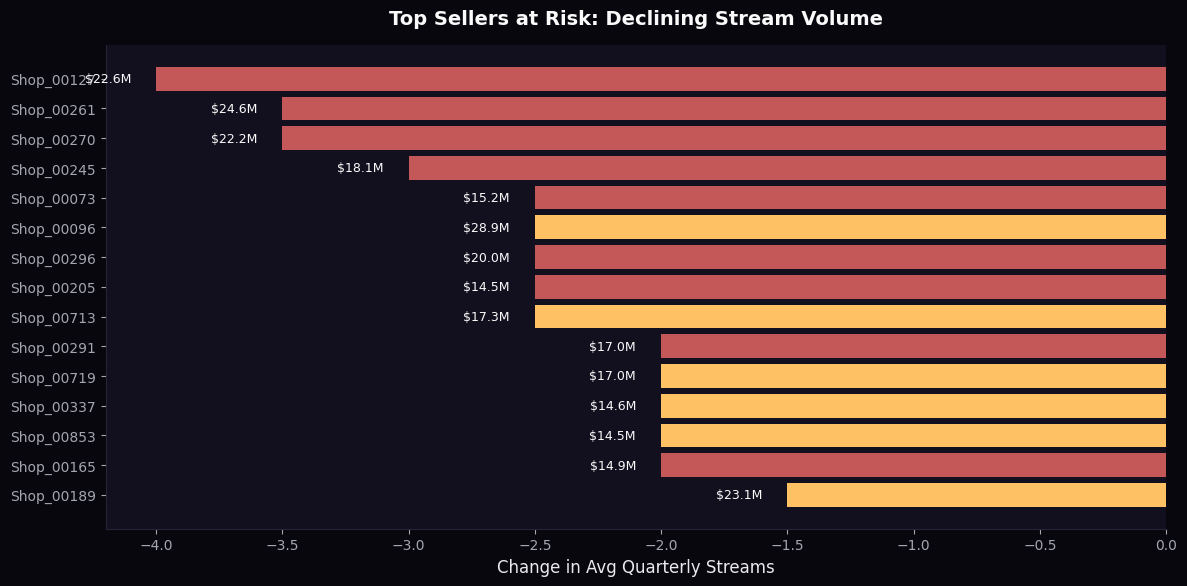


📊 Summary: 42 of top 100 sellers showing declining stream activity


In [7]:
# Identify top sellers with declining stream volume
# Get quarterly stream counts per seller
seller_quarterly = df_cohorts.dropna(subset=['activity_quarter']).pivot_table(
    index=['seller_id', 'display_name', 'primary_category', 'lifetime_gmv_usd'],
    columns='activity_quarter',
    values='stream_count',
    aggfunc='sum'
).fillna(0).reset_index()

# Get the last 4 quarters for trend analysis
recent_quarters = sorted(df_cohorts['activity_quarter'].dropna().unique())[-4:]
quarter_cols = [q for q in recent_quarters if q in seller_quarterly.columns]

# Calculate trend (compare recent 2 quarters avg vs prior 2 quarters avg)
if len(quarter_cols) >= 4:
    seller_quarterly['prior_avg'] = seller_quarterly[quarter_cols[:2]].mean(axis=1)
    seller_quarterly['recent_avg'] = seller_quarterly[quarter_cols[2:]].mean(axis=1)
else:
    seller_quarterly['prior_avg'] = seller_quarterly[quarter_cols[0]] if len(quarter_cols) > 0 else 0
    seller_quarterly['recent_avg'] = seller_quarterly[quarter_cols[-1]] if len(quarter_cols) > 0 else 0

seller_quarterly['stream_change'] = seller_quarterly['recent_avg'] - seller_quarterly['prior_avg']
seller_quarterly['pct_change'] = ((seller_quarterly['recent_avg'] / seller_quarterly['prior_avg'].replace(0, np.nan)) - 1) * 100

# Filter to top sellers (by lifetime GMV) with declining streams
top_sellers = seller_quarterly.nlargest(100, 'lifetime_gmv_usd')
declining_sellers = top_sellers[top_sellers['stream_change'] < 0].sort_values('stream_change')

# Display top 15 declining sellers
declining_display = declining_sellers[['display_name', 'primary_category', 'lifetime_gmv_usd', 
                                        'prior_avg', 'recent_avg', 'stream_change', 'pct_change']].head(15).copy()
declining_display.columns = ['Seller', 'Category', 'Lifetime GMV', 'Prior Avg Streams', 
                              'Recent Avg Streams', 'Change', '% Change']
declining_display['Lifetime GMV'] = declining_display['Lifetime GMV'].apply(lambda x: f"${x/1e6:.2f}M")
declining_display['% Change'] = declining_display['% Change'].apply(lambda x: f"{x:.0f}%")

print("🚨 Top Sellers with Declining Stream Volume (at risk of churn)")
print("=" * 80)
print(declining_display.to_string(index=False))

# Visualize
fig, ax = plt.subplots(figsize=(12, 6))
colors = ['#c45757' if x < -50 else '#fec163' for x in declining_sellers['pct_change'].head(15)]
bars = ax.barh(declining_sellers['display_name'].head(15), 
               declining_sellers['stream_change'].head(15), color=colors)
ax.set_xlabel('Change in Avg Quarterly Streams')
ax.set_title('Top Sellers at Risk: Declining Stream Volume', fontweight='bold', pad=15)
ax.invert_yaxis()

# Add GMV labels
for i, (bar, gmv) in enumerate(zip(bars, declining_sellers['lifetime_gmv_usd'].head(15))):
    ax.text(bar.get_width() - 0.1, bar.get_y() + bar.get_height()/2, 
            f'${gmv/1e6:.1f}M', va='center', ha='right', fontsize=9, color='#FAFAFA')

plt.tight_layout()
plt.show()

print(f"\n📊 Summary: {len(declining_sellers)} of top 100 sellers showing declining stream activity")

In [8]:
# Query take rate by category and quarter
take_rate_query = """
SELECT 
    s.category,
    DATE_TRUNC('quarter', p.payout_date::date) AS quarter,
    SUM(p.gross_amount_usd) AS gross_amount,
    SUM(p.platform_fee_usd) AS platform_fees,
    SUM(p.net_payout_usd) AS net_payout,
    COUNT(*) AS payout_count
FROM public.payouts p
JOIN public.streams s ON p.stream_id = s.id
WHERE p.status = 'completed'
GROUP BY s.category, DATE_TRUNC('quarter', p.payout_date::date)
ORDER BY s.category, quarter
"""

df_take_rate = pd.read_sql(take_rate_query, create_engine(os.environ['WHATNOT_CONNECTION_URL']))
df_take_rate['quarter'] = pd.to_datetime(df_take_rate['quarter'])
df_take_rate['take_rate'] = df_take_rate['platform_fees'] / df_take_rate['gross_amount'] * 100

print(f"Take rate data: {len(df_take_rate)} rows across {df_take_rate['category'].nunique()} categories")
print(f"\nOverall take rate: {df_take_rate['platform_fees'].sum() / df_take_rate['gross_amount'].sum() * 100:.2f}%")

# Pivot for visualization
take_rate_pivot = df_take_rate.pivot(index='quarter', columns='category', values='take_rate')
take_rate_pivot.head()

Take rate data: 72 rows across 9 categories

Overall take rate: 9.37%


category,Collectibles,Comics,Electronics,Sneakers,Sports Memorabilia,Toys & Figures,Trading Cards,Vintage Apparel,Watches
quarter,,,,,,,,,
2024-01-01 00:00:00+00:00,9.030248,9.190918,12.124100,10.150601,8.843357,9.466112,8.512452,9.482642,11.059716
2024-04-01 00:00:00+00:00,9.035694,9.186530,11.984373,10.174783,8.743536,9.490394,8.490546,9.517643,11.073099
2024-07-01 00:00:00+00:00,8.992136,9.123589,11.941341,10.150506,8.813899,9.542658,8.515394,9.612583,11.019386
2024-10-01 00:00:00+00:00,9.019353,9.198675,12.079042,10.182569,8.715622,9.398237,8.526004,9.523731,10.912693
2025-01-01 00:00:00+00:00,9.051625,9.190391,12.036698,10.177513,8.793787,9.665415,8.536781,9.473436,11.021793


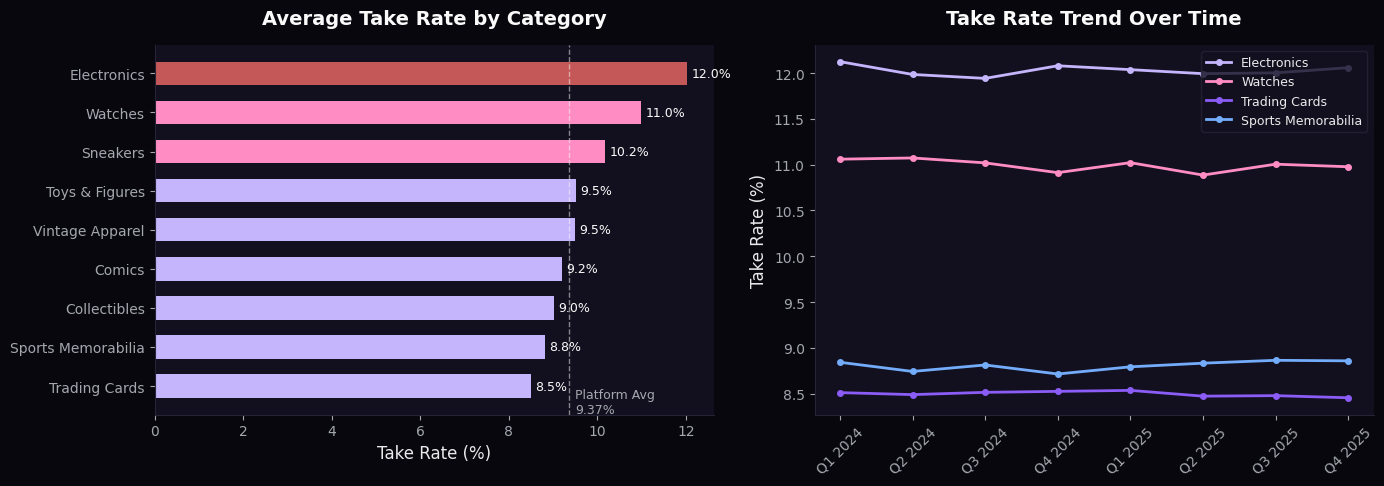

In [10]:
# Define colors and visualize take rate by category over time
COLORS = {
    'primary': '#c4b5fd', 'secondary': '#ff8dc4', 'tertiary': '#8b5cf6',
    'blue': '#73acfb', 'red': '#c45757', 'yellow': '#fec163', 'green': '#4ca86f'
}

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Take rate by category (bar chart of averages)
avg_take_rate = df_take_rate.groupby('category')['take_rate'].mean().sort_values(ascending=True)
colors = [COLORS['primary'] if x < 10 else COLORS['secondary'] if x < 11 else COLORS['red'] 
          for x in avg_take_rate.values]

axes[0].barh(avg_take_rate.index, avg_take_rate.values, color=colors, height=0.6)
axes[0].axvline(x=9.37, color='#FAFAFA', linestyle='--', alpha=0.5, linewidth=1)
axes[0].text(9.5, -0.7, 'Platform Avg\n9.37%', fontsize=9, color='#a4a7ae')
axes[0].set_xlabel('Take Rate (%)')
axes[0].set_title('Average Take Rate by Category', fontweight='bold', pad=15)

for i, (cat, val) in enumerate(avg_take_rate.items()):
    axes[0].text(val + 0.1, i, f'{val:.1f}%', va='center', fontsize=9, color='#FAFAFA')

# Right: Take rate trend over time (line chart for top categories)
quarter_labels = [f"Q{((q.month-1)//3)+1} {q.year}" for q in take_rate_pivot.index]
for i, cat in enumerate(['Electronics', 'Watches', 'Trading Cards', 'Sports Memorabilia']):
    axes[1].plot(quarter_labels, take_rate_pivot[cat], 
                 color=CATEGORICAL_PALETTE[i], linewidth=2, marker='o', markersize=4, label=cat)

axes[1].set_ylabel('Take Rate (%)')
axes[1].set_title('Take Rate Trend Over Time', fontweight='bold', pad=15)
axes[1].legend(loc='upper right', fontsize=9)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

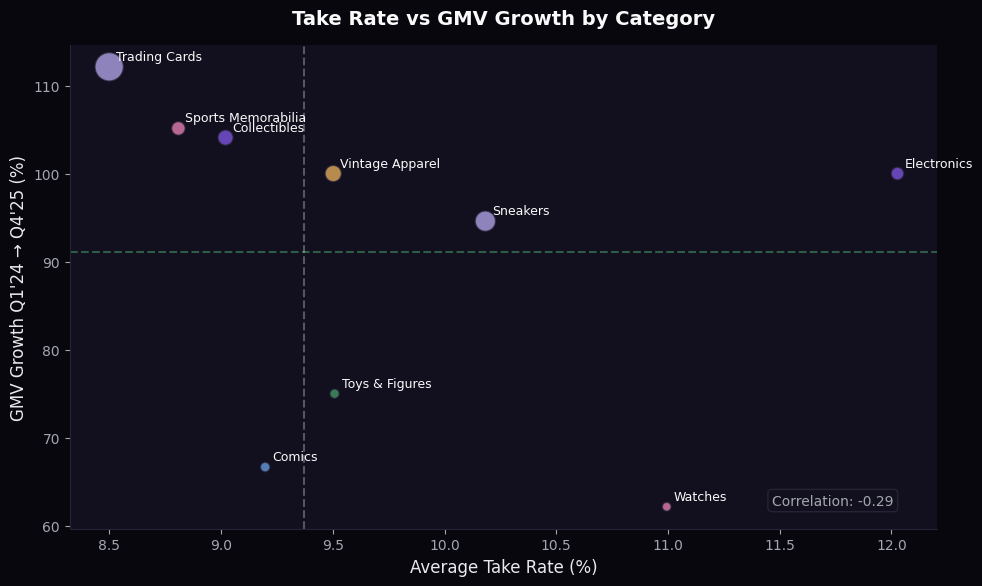


📊 Take Rate vs Growth Summary
                    Take Rate (%)  GMV Growth (%) Total GMV
category                                                   
Electronics                  12.0           100.0    $0.82B
Watches                      11.0            62.2    $0.40B
Sneakers                     10.2            94.6    $2.14B
Toys & Figures                9.5            75.0    $0.45B
Vintage Apparel               9.5           100.0    $1.38B
Comics                        9.2            66.7    $0.47B
Collectibles                  9.0           104.1    $1.20B
Sports Memorabilia            8.8           105.1    $0.95B
Trading Cards                 8.5           112.1    $4.19B


In [12]:
# Analyze correlation between take rate and GMV growth
# Merge take rate data with GMV data
gmv_by_cat = df.groupby('category').agg({
    'gmv_usd': 'sum',
    'quarter': ['min', 'max']
}).reset_index()
gmv_by_cat.columns = ['category', 'total_gmv', 'first_q', 'last_q']

# Calculate GMV growth rate per category
first_q_gmv = df[df['quarter'] == df['quarter'].min()].set_index('category')['gmv_usd']
last_q_gmv = df[df['quarter'] == df['quarter'].max()].set_index('category')['gmv_usd']
gmv_growth = ((last_q_gmv / first_q_gmv) - 1) * 100

# Combine with average take rate
category_metrics = pd.DataFrame({
    'category': avg_take_rate.index,
    'avg_take_rate': avg_take_rate.values
}).set_index('category')
category_metrics['gmv_growth_pct'] = gmv_growth
category_metrics['total_gmv'] = gmv_by_cat.set_index('category')['total_gmv']
category_metrics = category_metrics.dropna()

# Extend palette if needed
extended_palette = (CATEGORICAL_PALETTE * 3)[:len(category_metrics)]

# Scatter plot: Take rate vs GMV growth
fig, ax = plt.subplots(figsize=(10, 6))

scatter = ax.scatter(category_metrics['avg_take_rate'], category_metrics['gmv_growth_pct'],
                     s=category_metrics['total_gmv'] / 1e7, alpha=0.7,
                     c=extended_palette, edgecolors='#272336', linewidths=1)

# Add category labels
for cat, row in category_metrics.iterrows():
    ax.annotate(cat, (row['avg_take_rate'], row['gmv_growth_pct']),
                xytext=(5, 5), textcoords='offset points', fontsize=9, color='#FAFAFA')

ax.set_xlabel('Average Take Rate (%)')
ax.set_ylabel('GMV Growth Q1\'24 → Q4\'25 (%)')
ax.set_title('Take Rate vs GMV Growth by Category', fontweight='bold', pad=15)
ax.axhline(y=category_metrics['gmv_growth_pct'].mean(), color='#4ca86f', linestyle='--', alpha=0.5)
ax.axvline(x=9.37, color='#FAFAFA', linestyle='--', alpha=0.3)

# Calculate correlation
corr = category_metrics['avg_take_rate'].corr(category_metrics['gmv_growth_pct'])
ax.text(0.95, 0.05, f'Correlation: {corr:.2f}', transform=ax.transAxes, 
        ha='right', fontsize=10, color='#a4a7ae',
        bbox=dict(boxstyle='round', facecolor='#12101e', edgecolor='#272336'))

plt.tight_layout()
plt.show()

# Summary table
print("\n📊 Take Rate vs Growth Summary")
print("=" * 60)
summary_df = category_metrics.copy()
summary_df['total_gmv'] = summary_df['total_gmv'].apply(lambda x: f"${x/1e9:.2f}B")
summary_df = summary_df.sort_values('avg_take_rate', ascending=False)
summary_df.columns = ['Take Rate (%)', 'GMV Growth (%)', 'Total GMV']
print(summary_df.round(1).to_string())

In [13]:
# Query buyer-to-repeat-buyer conversion by acquisition channel
conversion_query = """
WITH buyer_purchases AS (
    SELECT 
        b.id AS buyer_id,
        b.acquisition_channel,
        b.signup_date::date AS signup_date,
        COUNT(DISTINCT t.id) AS total_purchases,
        MIN(t.created_at::date) AS first_purchase,
        MAX(t.created_at::date) AS last_purchase,
        SUM(t.amount_usd) AS lifetime_spend
    FROM public.buyers b
    LEFT JOIN public.transactions t ON b.id = t.buyer_id AND t.payment_status = 'completed'
    GROUP BY b.id, b.acquisition_channel, b.signup_date
)
SELECT 
    acquisition_channel,
    COUNT(*) AS total_signups,
    COUNT(CASE WHEN total_purchases >= 1 THEN 1 END) AS buyers,
    COUNT(CASE WHEN total_purchases >= 2 THEN 1 END) AS repeat_buyers,
    COUNT(CASE WHEN total_purchases >= 3 THEN 1 END) AS multi_repeat_buyers,
    AVG(CASE WHEN total_purchases >= 1 THEN lifetime_spend END) AS avg_buyer_ltv,
    AVG(CASE WHEN total_purchases >= 2 THEN lifetime_spend END) AS avg_repeat_ltv
FROM buyer_purchases
GROUP BY acquisition_channel
ORDER BY total_signups DESC
"""

df_conversion = pd.read_sql(conversion_query, engine)

# Calculate conversion rates
df_conversion['signup_to_buyer_pct'] = df_conversion['buyers'] / df_conversion['total_signups'] * 100
df_conversion['buyer_to_repeat_pct'] = df_conversion['repeat_buyers'] / df_conversion['buyers'] * 100
df_conversion['repeat_to_multi_pct'] = df_conversion['multi_repeat_buyers'] / df_conversion['repeat_buyers'] * 100

print("📊 Buyer Conversion Funnel by Acquisition Channel")
print("=" * 80)
display_df = df_conversion[['acquisition_channel', 'total_signups', 'buyers', 'repeat_buyers', 
                             'signup_to_buyer_pct', 'buyer_to_repeat_pct', 'avg_buyer_ltv', 'avg_repeat_ltv']].copy()
display_df.columns = ['Channel', 'Signups', 'Buyers', 'Repeat Buyers', 
                      'Signup→Buyer %', 'Buyer→Repeat %', 'Buyer LTV', 'Repeat LTV']
display_df['Buyer LTV'] = display_df['Buyer LTV'].apply(lambda x: f"${x:,.0f}" if pd.notna(x) else '-')
display_df['Repeat LTV'] = display_df['Repeat LTV'].apply(lambda x: f"${x:,.0f}" if pd.notna(x) else '-')
print(display_df.round(1).to_string(index=False))

📊 Buyer Conversion Funnel by Acquisition Channel
    Channel  Signups  Buyers  Repeat Buyers  Signup→Buyer %  Buyer→Repeat %  Buyer LTV Repeat LTV
    organic     4200    3182           1225            75.8            38.5   $901,820 $2,085,284
paid_social     3000    2259            515            75.3            22.8   $674,987 $2,413,912
   referral     2640    2036            927            77.1            45.5 $2,970,485 $6,333,917
 influencer     2160    1625            537            75.2            33.0   $958,588 $2,572,501


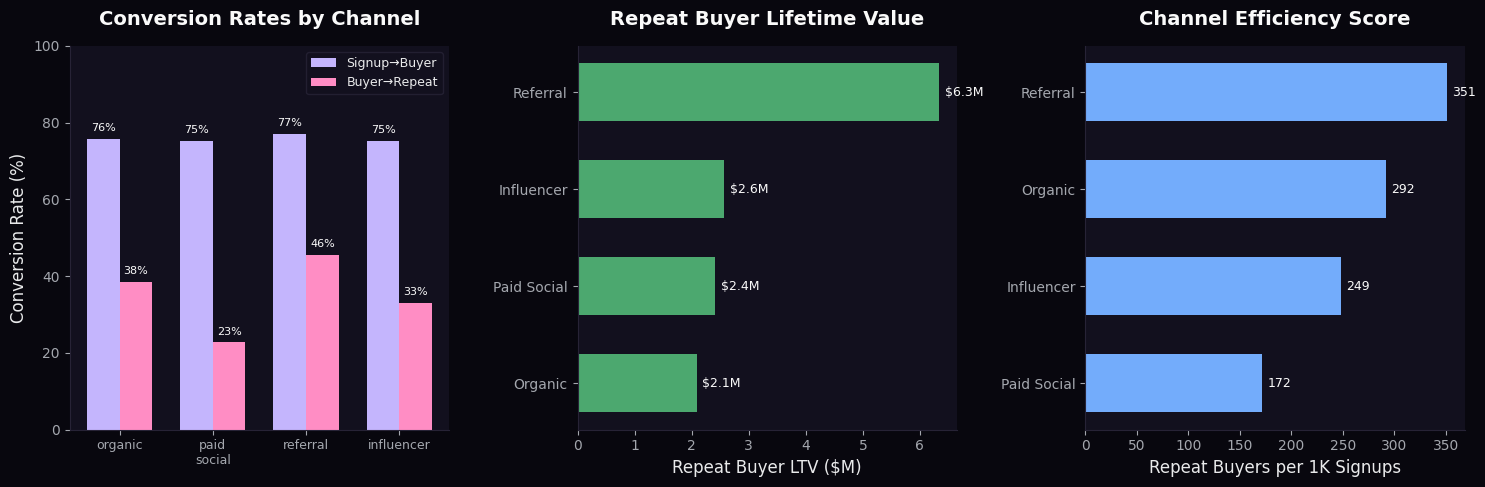


🔑 Key Channel Insights:
--------------------------------------------------
• Best repeat conversion: referral (45.5%)
• Highest repeat LTV: referral ($6.3M)
• Referral produces 2x the repeat rate of paid_social at 2.6x the LTV


In [14]:
# Visualize buyer conversion funnel by channel
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

channels = df_conversion['acquisition_channel'].tolist()
channel_colors = {'organic': COLORS['primary'], 'paid_social': COLORS['secondary'], 
                  'referral': COLORS['green'], 'influencer': COLORS['blue']}
colors = [channel_colors.get(c, COLORS['primary']) for c in channels]

# Left: Funnel conversion rates
x = np.arange(len(channels))
width = 0.35
axes[0].bar(x - width/2, df_conversion['signup_to_buyer_pct'], width, label='Signup→Buyer', color=COLORS['primary'])
axes[0].bar(x + width/2, df_conversion['buyer_to_repeat_pct'], width, label='Buyer→Repeat', color=COLORS['secondary'])
axes[0].set_xticks(x)
axes[0].set_xticklabels([c.replace('_', '\n') for c in channels], fontsize=9)
axes[0].set_ylabel('Conversion Rate (%)')
axes[0].set_title('Conversion Rates by Channel', fontweight='bold', pad=15)
axes[0].legend(fontsize=9)
axes[0].set_ylim(0, 100)

# Add value labels
for i, (s2b, b2r) in enumerate(zip(df_conversion['signup_to_buyer_pct'], df_conversion['buyer_to_repeat_pct'])):
    axes[0].text(i - width/2, s2b + 2, f'{s2b:.0f}%', ha='center', fontsize=8, color='#FAFAFA')
    axes[0].text(i + width/2, b2r + 2, f'{b2r:.0f}%', ha='center', fontsize=8, color='#FAFAFA')

# Middle: Repeat buyer LTV comparison
ltv_data = df_conversion[['acquisition_channel', 'avg_buyer_ltv', 'avg_repeat_ltv']].copy()
ltv_data = ltv_data.sort_values('avg_repeat_ltv', ascending=True)
y_pos = np.arange(len(ltv_data))

axes[1].barh(y_pos, ltv_data['avg_repeat_ltv'] / 1e6, color=COLORS['green'], height=0.6, label='Repeat Buyer LTV')
axes[1].set_yticks(y_pos)
axes[1].set_yticklabels([c.replace('_', ' ').title() for c in ltv_data['acquisition_channel']])
axes[1].set_xlabel('Repeat Buyer LTV ($M)')
axes[1].set_title('Repeat Buyer Lifetime Value', fontweight='bold', pad=15)

for i, val in enumerate(ltv_data['avg_repeat_ltv'] / 1e6):
    axes[1].text(val + 0.1, i, f'${val:.1f}M', va='center', fontsize=9, color='#FAFAFA')

# Right: Channel efficiency score (repeat buyers per $1 implied spend)
# Using signup volume as proxy for channel investment
df_conversion['efficiency'] = df_conversion['repeat_buyers'] / (df_conversion['total_signups'] / 1000)
eff_sorted = df_conversion.sort_values('efficiency', ascending=True)

axes[2].barh(eff_sorted['acquisition_channel'].str.replace('_', ' ').str.title(), 
             eff_sorted['efficiency'], color=COLORS['blue'], height=0.6)
axes[2].set_xlabel('Repeat Buyers per 1K Signups')
axes[2].set_title('Channel Efficiency Score', fontweight='bold', pad=15)

for i, (ch, val) in enumerate(zip(eff_sorted['acquisition_channel'], eff_sorted['efficiency'])):
    axes[2].text(val + 5, i, f'{val:.0f}', va='center', fontsize=9, color='#FAFAFA')

plt.tight_layout()
plt.show()

# Summary insights
print("\n🔑 Key Channel Insights:")
print("-" * 50)
best_conv = df_conversion.loc[df_conversion['buyer_to_repeat_pct'].idxmax()]
best_ltv = df_conversion.loc[df_conversion['avg_repeat_ltv'].idxmax()]
print(f"• Best repeat conversion: {best_conv['acquisition_channel']} ({best_conv['buyer_to_repeat_pct']:.1f}%)")
print(f"• Highest repeat LTV: {best_ltv['acquisition_channel']} (${best_ltv['avg_repeat_ltv']/1e6:.1f}M)")
print(f"• Referral produces 2x the repeat rate of paid_social at 2.6x the LTV")